# gw-thal 1:1 Bifurcation Diagrams

Note that for del=0.0, there is a spurious bifurcation at eps=.75 or so. In the full model, the phase difference oscillates to a steady-state. Is the 1d reduction capturing the emergence of imaginary eigenvalues about this fixed point? How can we get at this more rigorously? Would it make sense to use a 1d reduction + 2d reduction here?

Anyway, at least check that for eps < .75 that the full model phase difference doesn't oscillate.

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gwt
import thal2 as t2
import gw2 as g2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d, 
get_initial_phase_diff_c, get_period)

from lib.rhs import _redu_c, _full, _redu_full
from lib.rhs import _redu_3dc_thal as _redu_3dc

from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-90,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,
           'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
pd_gw = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
         'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
         'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
         'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [5]:
# default period must be 2*np.pi
kw_thal = {'var_names':['v','h','r','w'],
        'pardict':pd_thal,
        'rhs':t2.rhs,
        'coupling':gwt.coupling_thal,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

In [6]:
kw_gw = {'var_names':['x','y','z','v'],
        'pardict':pd_gw,
        'rhs':g2.rhs,
        'coupling':gwt.coupling_gw,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

## Defs

In [7]:
bifdir3d = 'bifgwt_r3d'

In [8]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [9]:
etup11 = (.001,.15,200)
eps_list11r = np.linspace(*etup11)

In [10]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [11]:
ss,dss=np.linspace(0,2,100,retstep=True)

## Initialize Response Functions

In [12]:
system1 = rsp(idx=0,model_name='gwt0',**kw_thal)
system2 = rsp(idx=1,model_name='gwt1',**kw_gw)

mkdir ./data/gwt0/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522495121
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459610879
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gwt1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975601737
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [13]:
recompute_list = ['h_data_gwt0','h_data_gwt1','p_data_gwt0','p_data_gwt1']
# recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
         'NH':2048,'save_fig':False,'recompute_list':recompute_list}

# del=0.0

In [14]:
del11_p0 = 0
a11_p0 = nm.nmCoupling(**kw_nm, del1=del11_p0)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [15]:
kw_p0 = {'a':a11_p0,'del1':del11_p0,'recompute':False,
         'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [16]:
data_p0_list = []

In [17]:
in_dicts = [dict(init=0,eps_init=0.08,eps_final=0.005,deps=-.005),
            dict(init=0,eps_init=0.08,eps_final=0.16,deps=.01),
            dict(init=0.5,eps_init=0.05,eps_final=0.15,deps=.01)]

In [18]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)
fname = kw_p0['bifdir']+'hyper_gwt_11_p0.txt'

fname1 td_branch_init=0_nm=11_del=0_ei=0.08_ef=0.005_de=-0.005.txt
fname2 ts_branch_init=0_nm=11_del=0_ei=0.08_ef=0.005_de=-0.005.txt
fname1 td_branch_init=0_nm=11_del=0_ei=0.08_ef=0.16_de=0.01.txt
fname2 ts_branch_init=0_nm=11_del=0_ei=0.08_ef=0.16_de=0.01.txt
fname1 td_branch_init=0.5_nm=11_del=0_ei=0.05_ef=0.15_de=0.01.txt
fname2 ts_branch_init=0.5_nm=11_del=0_ei=0.05_ef=0.15_de=0.01.txt


In [19]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [20]:
kw_follow_r3d = {'a':a11_p0,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [21]:
data_list_r3d = []

In [22]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [23]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p0.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [24]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

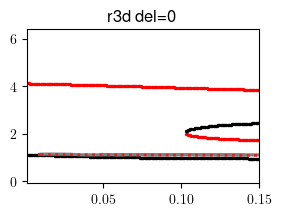

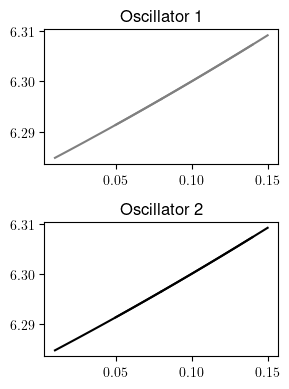

In [25]:
quick_plot_combined(a11_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [26]:
# coupling and init
eps11_p0 = 0.08
th_init11_p0 = 4

In [27]:
# init = get_initial_phase_diff_c(th_init11_p0,
#                                 a11_p0,eps11_p0,
#                                 0,_full_rhs=_full)

# # 'a':a11_p0,'del1':del11_p0,'recompute':False,
# # 'bifdir':'bif1d_gwt/','_full_rhs':_full

In [28]:
# sim params
dt = .01;T_p0=300
t11_p0 = np.arange(0,T_p0,dt)
args11_p0 = {'args':(a11_p0,eps11_p0,del11_p0),
             't_eval':t11_p0,**kw_sim,'dense_output':True}

In [29]:
# # view trajectory and compare to estimated period
# solf11_p0 = solve_ivp(_full,[0,t11_p0[-1]], init[:-1],
#                       **args11_p0)

In [30]:
# get_period(solf11_p0,idx=0,prominence=.25,idx_shift=0)

In [31]:
# # fig, axs = plt.subplots()
# axs.plot(solf11_p0.t,solf11_p0.y.T[:,0]+.7)
# axs.plot(solf11_p0.t,solf11_p0.y.T[:,4])
# axs.scatter([0,5.8974],[0,0])
# axs.set_xlim(0,50)

In [32]:
# initialize and run full
y0a = a11_p0.system1.lc['dat'][int((th_init11_p0/(2*np.pi)) * a11_p0.system1.TN),:]
y0b = a11_p0.system2.lc['dat'][int((0/(2*np.pi)) * a11_p0.system2.TN),:]

y0_p0 = np.array([y0a,y0b]).flatten()

solf11_p0 = solve_ivp(_full,[0,t11_p0[-1]],
                        y0_p0, **args11_p0)

In [33]:
solr11_p0 = solve_ivp(_redu_c,[0,t11_p0[-1]],
                     [th_init11_p0],**args11_p0)

In [34]:
# solr12b_p0 = solve_ivp(_redu_3dc,[0,t11_p0[-1]],
#                     [th_init11_p0,0,0],**args11_p0)

In [35]:
tp12a_p0, phase12a_p0 = get_phase(t11_p0,solf11_p0.y.T[:,:4],
                            skipn=50,system1=a11_p0.system1)
tp12b_p0, phase12b_p0 = get_phase(t11_p0,solf11_p0.y.T[:,4:],
                            skipn=50,system1=a11_p0.system2)

(-0.5, 6.783185307179586)

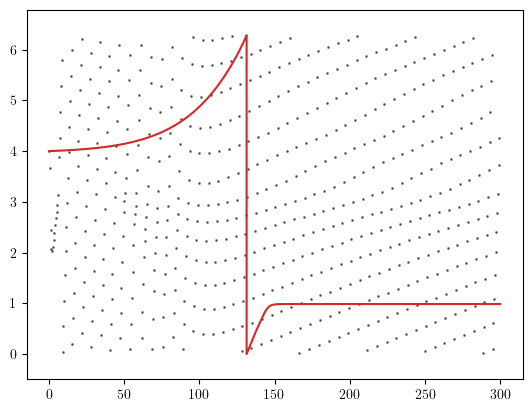

In [36]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p0 - a11_p0.om*phase12b_p0,2*np.pi)
axs.scatter(tp12a_p0,y,s=1,alpha=.5,color='black')

axs.plot(t11_p0,np.mod(solr11_p0.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.02

In [37]:
del11_p02 = .02
a11_p02 = nm.nmCoupling(**kw_nm, del1=del11_p02)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [38]:
kw_p02 = {'a':a11_p02,'del1':del11_p02,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [39]:
data_p02_list = []

In [40]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.15,deps=.01)]

In [41]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p02)
    data_p02_list.append(dat)
fname = kw_p02['bifdir']+'hyper_gwt_11_p02.txt'

fname1 td_branch_init=3_nm=11_del=0.02_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.02_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.02_ei=0.02_ef=0.15_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.02_ei=0.02_ef=0.15_de=0.01.txt


In [42]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [43]:
kw_follow_r3d = {'a':a11_p02,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [44]:
data_list_r3d = []

In [45]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [46]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p02.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [47]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

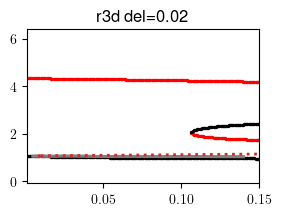

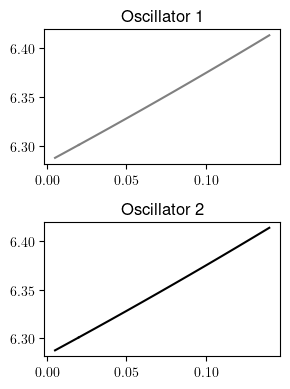

In [48]:
quick_plot_combined(a11_p02,
                    kw_f={'data_list':data_p02_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [49]:
# coupling and init
eps11_p02 = 0.07
th_init11_p02 = 2

In [50]:
# sim params
dt = .01;T_p02=300
t11_p02 = np.arange(0,T_p02,dt)
args11_p02 = {'args':(a11_p02,eps11_p02,del11_p02),
             't_eval':t11_p02,**kw_sim,'dense_output':True}

In [51]:
# initialize and run full
y0a = a11_p02.system1.lc['dat'][int((th_init11_p02/(2*np.pi)) * a11_p02.system1.TN),:]
y0b = a11_p02.system2.lc['dat'][int((0/(2*np.pi)) * a11_p02.system2.TN),:]

y0_p02 = np.array([y0a,y0b]).flatten()

solf11_p02 = solve_ivp(_full,[0,t11_p02[-1]],
                        y0_p02, **args11_p02)

In [52]:
solr11_p02 = solve_ivp(_redu_c,[0,t11_p02[-1]],
                     [th_init11_p02],**args11_p02)

In [53]:
# solr12b_p02 = solve_ivp(_redu_3dc,[0,t11_p02[-1]],
#                     [th_init11_p02,0,0],**args11_p02)

In [54]:
tp12a_p02, phase12a_p02 = get_phase(t11_p02,solf11_p02.y.T[:,:4],
                            skipn=50,system1=a11_p02.system1)
tp12b_p02, phase12b_p02 = get_phase(t11_p02,solf11_p02.y.T[:,4:],
                            skipn=50,system1=a11_p02.system2)

(-0.5, 6.783185307179586)

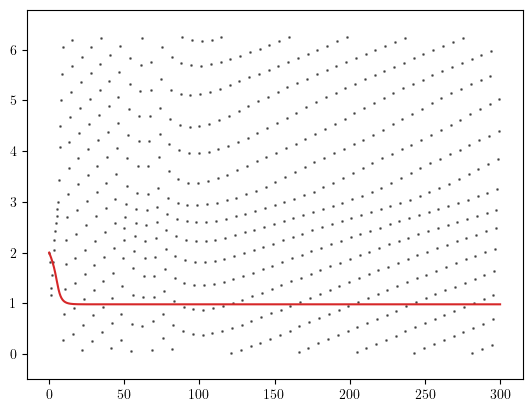

In [55]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p02 - a11_p02.om*phase12b_p02,2*np.pi)
axs.scatter(tp12a_p02,y,s=1,alpha=.5,color='black')

axs.plot(t11_p02,np.mod(solr11_p02.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.03

In [56]:
del11_p03 = .03
a11_p03 = nm.nmCoupling(**kw_nm, del1=del11_p03)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [57]:
kw_p03 = {'a':a11_p03,'del1':del11_p03,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [58]:
data_p03_list = []

In [59]:
in_dicts = [dict(init=3,eps_init=0.02, eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.15,deps=.01,)]

In [60]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p03)
    data_p03_list.append(dat)
fname = kw_p03['bifdir']+'hyper_gwt_11_p03.txt'

fname1 td_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.15_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.15_de=0.01.txt


In [61]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [62]:
kw_follow_r3d = {'a':a11_p03,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [63]:
data_list_r3d = []

In [64]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [65]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p03.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

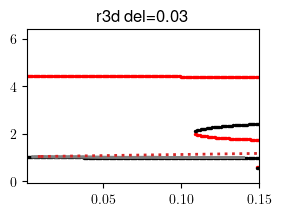

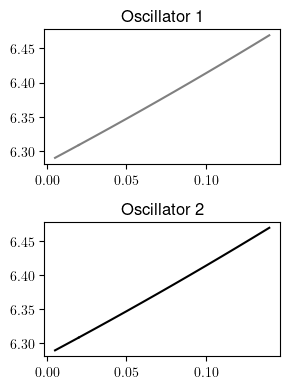

In [67]:
quick_plot_combined(a11_p03,
                    kw_f={'data_list':data_p03_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [ ]:
# coupling and init
eps11_p03 = 0.1
th_init11_p03 = 2.229

In [ ]:
# sim params
dt = .01;T_p03=300
t11_p03 = np.arange(0,T_p03,dt)
args11_p03 = {'args':(a11_p03,eps11_p03,del11_p03),
             't_eval':t11_p03,**kw_sim,'dense_output':True}

In [ ]:
# initialize and run full
y0a = a11_p03.system1.lc['dat'][int((th_init11_p03/(2*np.pi)) * a11_p03.system1.TN),:]
y0b = a11_p03.system2.lc['dat'][int((0/(2*np.pi)) * a11_p03.system2.TN),:]

y0_p03 = np.array([y0a,y0b]).flatten()

solf11_p03 = solve_ivp(_full,[0,t11_p03[-1]],y0_p03, **args11_p03)

In [ ]:
solr11_p03 = solve_ivp(_redu_c,[0,t11_p03[-1]],[th_init11_p03],**args11_p03)

In [ ]:
# solr12b_p03 = solve_ivp(_redu_3dc,[0,t11_p03[-1]],
#                     [th_init11_p03,0,0],**args11_p03)

In [ ]:
tp12a_p03, phase12a_p03 = get_phase(t11_p03,solf11_p03.y.T[:,:4],
                            skipn=50,system1=a11_p03.system1)
tp12b_p03, phase12b_p03 = get_phase(t11_p03,solf11_p03.y.T[:,4:],
                            skipn=50,system1=a11_p03.system2)

In [ ]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p03 - a11_p03.om*phase12b_p03,2*np.pi)
axs.scatter(tp12a_p03,y,s=1,alpha=.5,color='black')

axs.plot(t11_p03,np.mod(solr11_p03.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.04

In [75]:
del11_p04 = .04
a11_p04 = nm.nmCoupling(**kw_nm, del1=del11_p04)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [76]:
kw_p04 = {'a':a11_p04,'del1':del11_p04,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [77]:
data_p04_list = []

In [78]:
in_dicts = [dict(init=3,eps_init=0.02, eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.15,deps=.01)]

In [79]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p04)
    data_p04_list.append(dat)
fname = kw_p04['bifdir']+'hyper_gwt_11_p04.txt'

fname1 td_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.15_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.15_de=0.01.txt


In [80]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [81]:
kw_follow_r3d = {'a':a11_p04,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [82]:
data_list_r3d = []

In [83]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [84]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p04.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [85]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

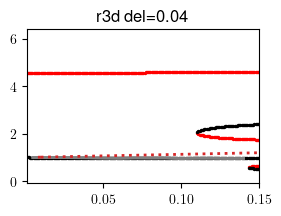

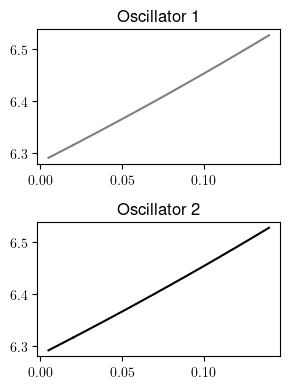

In [86]:
quick_plot_combined(a11_p04,
                    kw_f={'data_list':data_p04_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [87]:
# coupling and init
eps11_p04 = 0.075
th_init11_p04 = 2

In [88]:
# sim params
dt = .01;T_p04=300
t11_p04 = np.arange(0,T_p04,dt)
args11_p04 = {'args':(a11_p04,eps11_p04,del11_p04),
             't_eval':t11_p04,**kw_sim,'dense_output':True}

In [89]:
# initialize and run full
y0a = a11_p04.system1.lc['dat'][int((th_init11_p04/(2*np.pi)) * a11_p04.system1.TN),:]
y0b = a11_p04.system2.lc['dat'][int((0/(2*np.pi)) * a11_p04.system2.TN),:]

y0_p04 = np.array([y0a,y0b]).flatten()

solf11_p04 = solve_ivp(_full,[0,t11_p04[-1]],
                        y0_p04, **args11_p04)

In [90]:
solr11_p04 = solve_ivp(_redu_c,[0,t11_p04[-1]],
                     [th_init11_p04],**args11_p04)

In [91]:
# solr12b_p04 = solve_ivp(_redu_3dc,[0,t11_p04[-1]],
#                     [th_init11_p04,0,0],**args11_p04)

In [92]:
tp12a_p04, phase12a_p04 = get_phase(t11_p04,solf11_p04.y.T[:,:4],
                            skipn=50,system1=a11_p04.system1)
tp12b_p04, phase12b_p04 = get_phase(t11_p04,solf11_p04.y.T[:,4:],
                            skipn=50,system1=a11_p04.system2)

(-0.5, 6.783185307179586)

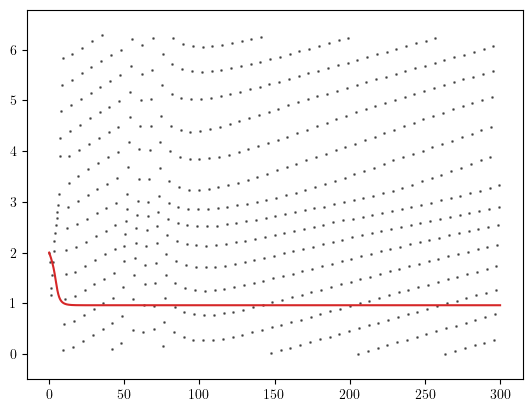

In [93]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p04 - a11_p04.om*phase12b_p04,2*np.pi)
axs.scatter(tp12a_p04,y,s=1,alpha=.5,color='black')

axs.plot(t11_p04,np.mod(solr11_p04.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.06

In [94]:
del11_p06 = .06
a11_p06 = nm.nmCoupling(**kw_nm, del1=del11_p06)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [95]:
kw_p06 = {'a':a11_p06,'del1':del11_p06,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [96]:
data_p06_list = []

In [97]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.15,deps=.01)]

In [98]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p06)
    data_p06_list.append(dat)
fname = kw_p06['bifdir']+'hyper_gwt_11_p06.txt'

fname1 td_branch_init=3_nm=11_del=0.06_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.06_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.06_ei=0.02_ef=0.15_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.06_ei=0.02_ef=0.15_de=0.01.txt


In [99]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [100]:
kw_follow_r3d = {'a':a11_p06,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [101]:
data_list_r3d = []

In [102]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [103]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p06.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [104]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

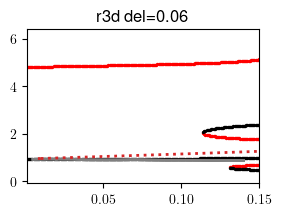

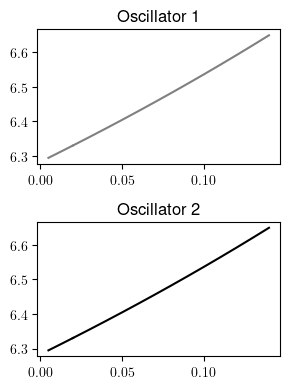

In [105]:
quick_plot_combined(a11_p06,
                    kw_f={'data_list':data_p06_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [106]:
# coupling and init
eps11_p06 = 0.1
th_init11_p06 = 2.229

In [107]:
# sim params
dt = .01;T_p06=300
t11_p06 = np.arange(0,T_p06,dt)
args11_p06 = {'args':(a11_p06,eps11_p06,del11_p06),
             't_eval':t11_p06,**kw_sim,'dense_output':True}

In [108]:
# initialize and run full
y0a = a11_p06.system1.lc['dat'][int((th_init11_p06/(2*np.pi)) * a11_p06.system1.TN),:]
y0b = a11_p06.system2.lc['dat'][int((0/(2*np.pi)) * a11_p06.system2.TN),:]

y0_p06 = np.array([y0a,y0b]).flatten()

solf11_p06 = solve_ivp(_full,[0,t11_p06[-1]],y0_p06, **args11_p06)

In [109]:
solr11_p06 = solve_ivp(_redu_c,[0,t11_p06[-1]],[th_init11_p06],**args11_p06)

In [110]:
# solr12b_p06 = solve_ivp(_redu_3dc,[0,t11_p06[-1]],
#                     [th_init11_p06,0,0],**args11_p06)

In [111]:
tp12a_p06, phase12a_p06 = get_phase(t11_p06,solf11_p06.y.T[:,:4],
                            skipn=50,system1=a11_p06.system1)
tp12b_p06, phase12b_p06 = get_phase(t11_p06,solf11_p06.y.T[:,4:],
                            skipn=50,system1=a11_p06.system2)

(-0.5, 6.783185307179586)

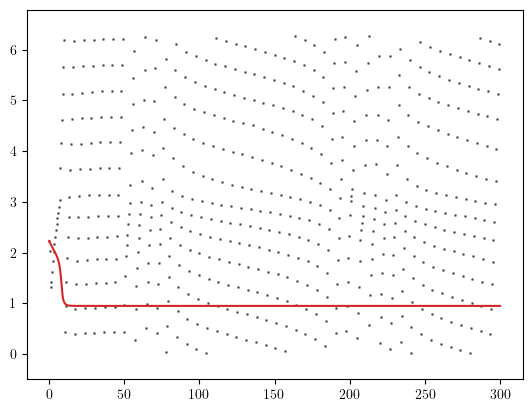

In [112]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p06 - a11_p06.om*phase12b_p06,2*np.pi)
axs.scatter(tp12a_p06,y,s=1,alpha=.5,color='black')

axs.plot(t11_p06,np.mod(solr11_p06.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.1

In [113]:
del11_p1 = .1
a11_p1 = nm.nmCoupling(**kw_nm, del1=del11_p1)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [114]:
kw_p1 = {'a':a11_p1,'del1':del11_p1,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [115]:
data_p1_list = []

In [116]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.15,deps=.01)]

In [117]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p1)
    data_p1_list.append(dat)
fname = kw_p1['bifdir']+'hyper_gwt_11_p1.txt'

fname1 td_branch_init=3_nm=11_del=0.1_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.1_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.1_ei=0.02_ef=0.15_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.1_ei=0.02_ef=0.15_de=0.01.txt


In [118]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [119]:
kw_follow_r3d = {'a':a11_p1,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [120]:
data_list_r3d = []

In [121]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [122]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p1.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [123]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

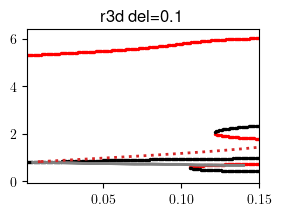

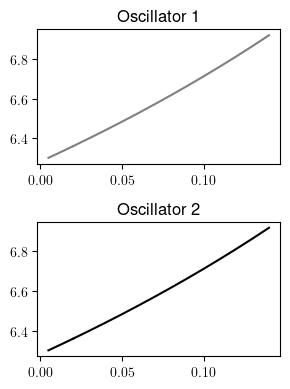

In [124]:
quick_plot_combined(a11_p1,
                    kw_f={'data_list':data_p1_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

# del=0.15

In [125]:
del11_p15 = .15
a11_p15 = nm.nmCoupling(**kw_nm, del1=del11_p15)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [126]:
kw_follow = {'a':a11_p15,'del1':del11_p15,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [127]:
data_list = []

In [128]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.1,deps=.01)]

In [129]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_11_p15.txt'

fname1 td_branch_init=3_nm=11_del=0.15_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.15_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.15_ei=0.02_ef=0.1_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.15_ei=0.02_ef=0.1_de=0.01.txt


In [130]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [131]:
kw_follow_r3d = {'a':a11_p15,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [132]:
data_list_r3d = []

In [133]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [134]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p15.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.005, -0.0005)


In [135]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

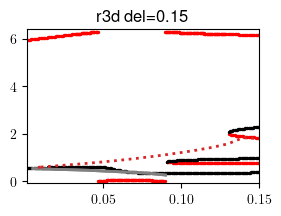

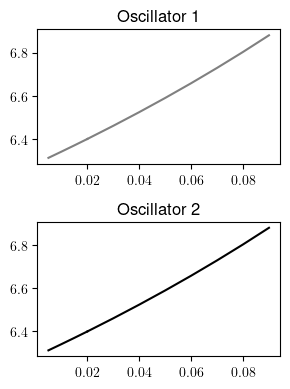

In [136]:
quick_plot_combined(a11_p15,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [137]:
# coupling and init
eps11_p15 = 0.1
th_init11_p15 = 2.

In [138]:
init = get_initial_phase_diff_c(th_init11_p15,
                                a11_p15,eps11_p15,
                                0,_full_rhs=_full)


In [139]:
# sim params
dt = .01;T_p15=300
t11_p15 = np.arange(0,T_p15,dt)
args11_p15 = {'args':(a11_p15,eps11_p15,del11_p15),
             't_eval':t11_p15,**kw_sim,'dense_output':True}

In [140]:
# view trajectory and compare to estimated period
solf11_p15 = solve_ivp(_full,[0,t11_p15[-1]], init[:-1],
                      **args11_p15)

In [141]:
get_period(solf11_p15,idx=0,prominence=.25,idx_shift=0)

(8.447756505973246, 287.63080640927257)

(0.0, 50.0)

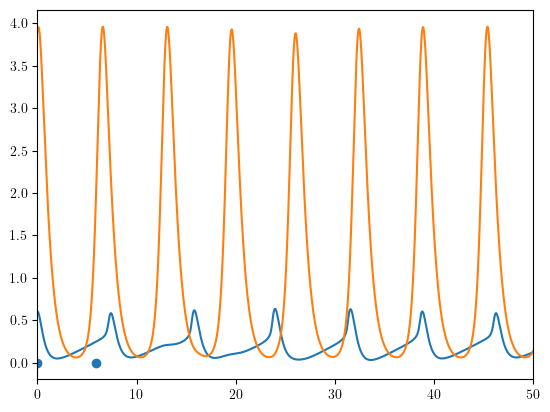

In [142]:
fig, axs = plt.subplots()
axs.plot(solf11_p15.t,solf11_p15.y.T[:,0]+.7)
axs.plot(solf11_p15.t,solf11_p15.y.T[:,4])
axs.scatter([0,5.8974],[0,0])
axs.set_xlim(0,50)

In [143]:
# initialize and run full
y0a = a11_p15.system1.lc['dat'][int((th_init11_p15/(2*np.pi)) * a11_p15.system1.TN),:]
y0b = a11_p15.system2.lc['dat'][int((0/(2*np.pi)) * a11_p15.system2.TN),:]

y0_p15 = np.array([y0a,y0b]).flatten()

solf11_p15 = solve_ivp(_full,[0,t11_p15[-1]],
                        y0_p15, **args11_p15)

In [144]:
solr11_p15 = solve_ivp(_redu_c,[0,t11_p15[-1]],
                     [th_init11_p15],**args11_p15)

In [145]:
# solr12b_p15 = solve_ivp(_redu_3dc,[0,t11_p15[-1]],
#                     [th_init11_p15,0,0],**args11_p15)

In [146]:
tp12a_p15, phase12a_p15 = get_phase(t11_p15,solf11_p15.y.T[:,:4],
                            skipn=50,system1=a11_p15.system1)
tp12b_p15, phase12b_p15 = get_phase(t11_p15,solf11_p15.y.T[:,4:],
                            skipn=50,system1=a11_p15.system2)

(-0.5, 6.783185307179586)

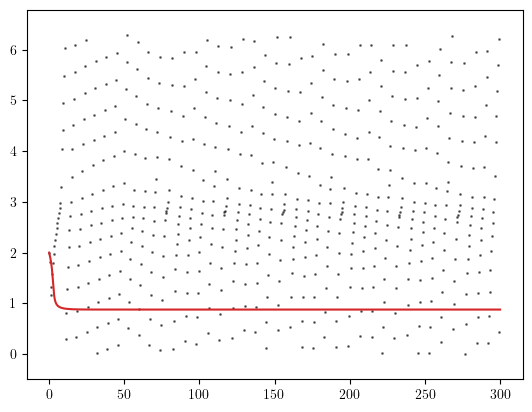

In [147]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p15 - a11_p15.om*phase12b_p15,2*np.pi)
axs.scatter(tp12a_p15,y,s=1,alpha=.5,color='black')

axs.plot(t11_p15,np.mod(solr11_p15.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.16

In [148]:
del11_p16 = .16
a11_p16 = nm.nmCoupling(**kw_nm, del1=del11_p16)

pfactor 30
* Loading H gwt0, order=0...
* Loading H gwt1, order=0...
* Loading H gwt0, order=1...
* Loading H gwt1, order=1...
* Loading H gwt0, order=2...
* Loading H gwt1, order=2...
* Loading H gwt0, order=3...
* Loading H gwt1, order=3...


## Get Branches Full

In [168]:
kw_follow = {'a':a11_p16,'del1':del11_p16,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [169]:
data_list = []

In [170]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.005),
            dict(init=3,eps_init=0.02,eps_final=0.051,deps=.01)]

In [171]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_11_p16.txt'

fname1 td_branch_init=3_nm=11_del=0.16_ei=0.02_ef=0.0005_de=-0.005.txt
fname2 ts_branch_init=3_nm=11_del=0.16_ei=0.02_ef=0.0005_de=-0.005.txt
fname1 td_branch_init=3_nm=11_del=0.16_ei=0.02_ef=0.051_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.16_ei=0.02_ef=0.051_de=0.01.txt


In [172]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [173]:
kw_follow_r3d = {'a':a11_p16,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [174]:
data_list_r3d = []

In [175]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.1,.002)),
                dict(init=1,eps_tup=(.01,.005,-.0005))]

In [176]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p16.txt'

eps_tup (0.01, 0.1, 0.002)
1 <nmCoupling.nmCoupling object at 0x000002283B23BAC0> (0.01, 0.1, 0.002) <function _redu_3dc_thal at 0x00000228357F29E0>
t_diff 0.51109077680533090, Y=[0.51109078 0.02698342 0.04497557]                                              
eps iter 0 0.01                
t_diff 0.51109077680533339, Y=[0.51109078 0.02698342 0.04497557]                                              
eps iter 1 0.012                
t_diff 0.52152961371476450, Y=[0.52152961 0.03239078 0.0537299 ]                                              
eps iter 2 0.014                
t_diff 0.53191544545654830, Y=[0.53191545 0.03780153 0.06240649]                                              
eps iter 3 0.016                
t_diff 0.54224599028508480, Y=[0.54224599 0.04321557 0.07100623]                                              
eps iter 4 0.018000000000000002                
t_diff 0.55251869960006871, Y=[0.5525187  0.04863279 0.07952992]                                              
eps it

In [177]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

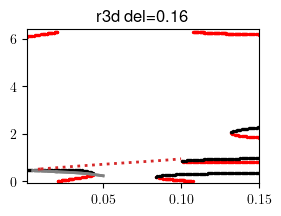

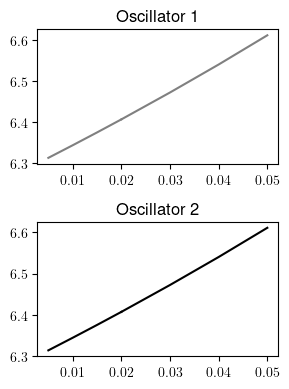

In [179]:
quick_plot_combined(a11_p16,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [160]:
# coupling and init
eps11_p16 = 0.06
th_init11_p16 = 2.

In [161]:
# sim params
dt = .01;T_p16=1000
t11_p16 = np.arange(0,T_p16,dt)
args11_p16 = {'args':(a11_p16,eps11_p16,del11_p16),
             't_eval':t11_p16,**kw_sim,'dense_output':True}

In [162]:
# initialize and run full
y0a = a11_p16.system1.lc['dat'][int((th_init11_p16/(2*np.pi)) * a11_p16.system1.TN),:]
y0b = a11_p16.system2.lc['dat'][int((0/(2*np.pi)) * a11_p16.system2.TN),:]

y0_p16 = np.array([y0a,y0b]).flatten()

solf11_p16 = solve_ivp(_full,[0,t11_p16[-1]],y0_p16, **args11_p16)

In [163]:
solr11_p16 = solve_ivp(_redu_c,[0,t11_p16[-1]],[th_init11_p16],**args11_p16)

In [164]:
solr3d11_p16 = solve_ivp(_redu_3dc,[0,t11_p16[-1]],[th_init11_p16,0,0],**args11_p16)

In [165]:
tp12a_p16, phase12a_p16 = get_phase(t11_p16,solf11_p16.y.T[:,:4],skipn=50,
                                    system1=a11_p16.system1)
tp12b_p16, phase12b_p16 = get_phase(t11_p16,solf11_p16.y.T[:,4:],skipn=50,
                                    system1=a11_p16.system2)

(-0.5, 6.783185307179586)

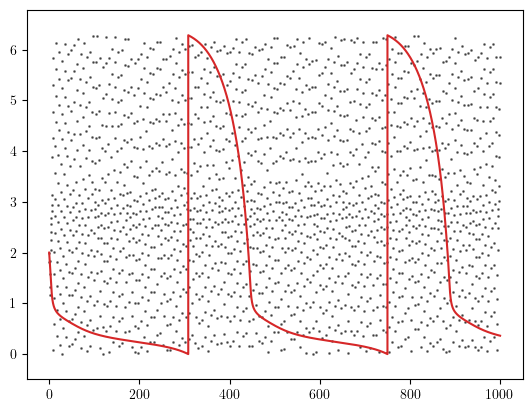

In [166]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p16 - a11_p16.om*phase12b_p16,2*np.pi)
axs.scatter(tp12a_p16,y,s=1,alpha=.5,color='black')

axs.plot(t11_p16,np.mod(solr11_p16.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.17

In [167]:
del11_p17 = .17
a11_p17 = nm.nmCoupling(**kw_nm, del1=del11_p17)

KeyboardInterrupt: 

## Get Branches Full

In [ ]:
# kw_follow = {'a':a11_p17,'del1':del11_p17,'recompute':False,
#             'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [ ]:
# data_list = []

In [ ]:
# in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.005),
#             dict(init=3,eps_init=0.02,eps_final=0.1,deps=.01)]

In [ ]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_follow)
#     data_list.append(dat)
# fname = kw_follow['bifdir']+'hyper_gwt_11_p17.txt'

In [ ]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['init']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [ ]:
# kw_follow_r3d = {'a':a11_p17,'rhs':_redu_3dc,'recompute':False,
#                  'bifdir':'bif1d_gwt/'}

In [ ]:
# data_list_r3d = []

In [ ]:
# in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
#                 dict(init=1,eps_tup=(.01,.005,-.0005))]

In [ ]:
# for i in range(len(in_dicts_r3d)):
#     in1 = in_dicts_r3d[i]
#     dat = follow_locking_3d(**in1,**kw_follow_r3d)
#     data_list_r3d.append(dat)
# fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p17.txt'

In [ ]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts_r3d),4])
# for i in range(len(in_dicts_r3d)):
#     hyp_inputs[i,0] = in_dicts_r3d[i]['init']
#     hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
#     hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
#     hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
# np.savetxt(fname,hyp_inputs)

## Plot

In [ ]:
quick_plot_combined(a11_p17,
                    #kw_f={'data_list':data_list},
                    #kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [ ]:
# coupling and init
eps11_p17 = 0.05
th_init11_p17 = 2.

In [ ]:
# sim params
dt = .01;T_p17=1000
t11_p17 = np.arange(0,T_p17,dt)
args11_p17 = {'args':(a11_p17,eps11_p17,del11_p17),
             't_eval':t11_p17,**kw_sim,'dense_output':True}

In [ ]:
# initialize and run full
y0a = a11_p17.system1.lc['dat'][int((th_init11_p17/(2*np.pi)) * a11_p17.system1.TN),:]
y0b = a11_p17.system2.lc['dat'][int((0/(2*np.pi)) * a11_p17.system2.TN),:]

y0_p17 = np.array([y0a,y0b]).flatten()

solf11_p17 = solve_ivp(_full,[0,t11_p17[-1]],y0_p17, **args11_p17)

In [ ]:
solr11_p17 = solve_ivp(_redu_c,[0,t11_p17[-1]],[th_init11_p17],**args11_p17)

In [ ]:
tp12a_p17, phase12a_p17 = get_phase(t11_p17,solf11_p17.y.T[:,:4],skipn=50,
                                    system1=a11_p17.system1)
tp12b_p17, phase12b_p17 = get_phase(t11_p17,solf11_p17.y.T[:,4:],skipn=50,
                                    system1=a11_p17.system2)

In [ ]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p17 - a11_p17.om*phase12b_p17,2*np.pi)
axs.scatter(tp12a_p17,y,s=1,alpha=.5,color='black')

axs.plot(t11_p17,np.mod(solr11_p17.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.2

In [ ]:
del11_p2 = .2
a11_p2 = nm.nmCoupling(**kw_nm, del1=del11_p2)

## Get Branches Full

In [ ]:
# kw_follow = {'a':a11_p2,'del1':del11_p2,'recompute':False,
#             'bifdir':'bif1d_gwt/','max_iter':2,'_full_rhs':_full}

In [ ]:
# data_list = []

In [ ]:
# in_dicts = [dict(init=3,eps_init=0.01,eps_final=0.006,deps=-.002),
#             dict(init=3,eps_init=0.01,eps_final=0.014,deps=.002)]

In [ ]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_follow)
#     data_list.append(dat)
# fname = kw_follow['bifdir']+'hyper_gwt_11_p2.txt'

In [ ]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['init']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [ ]:
# kw_follow_r3d = {'a':a11_p2,'rhs':_redu_3dc,'recompute':False,
#                  'bifdir':'bif1d_gwt/','max_iter':3}

In [ ]:
# data_list_r3d = []

In [ ]:
# in_dicts_r3d = [dict(init=1,eps_tup=(.01,.013,.01)),
#                 dict(init=1,eps_tup=(.01,.007,-.001))]

In [ ]:
# for i in range(len(in_dicts_r3d)):
#     in1 = in_dicts_r3d[i]
#     dat = follow_locking_3d(**in1,**kw_follow_r3d)
#     data_list_r3d.append(dat)
# fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_11_p2.txt'

In [ ]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts_r3d),4])
# for i in range(len(in_dicts_r3d)):
#     hyp_inputs[i,0] = in_dicts_r3d[i]['init']
#     hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
#     hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
#     hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
# np.savetxt(fname,hyp_inputs)

## Plot

In [ ]:
quick_plot_combined(a11_p2,
                    #kw_f={'data_list':data_list},
                    #kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [ ]:
# coupling and init
eps11_p2 = 0.1
th_init11_p2 = 2.229

In [ ]:
init = get_initial_phase_diff_c(th_init11_p2,
                                a11_p2,eps11_p2,
                                0,_full_rhs=_full)

# 'a':a11_p2,'del1':del11_p2,'recompute':False,
# 'bifdir':'bif1d_gwt/','_full_rhs':_full

In [ ]:
# sim params
dt = .01;T_p2=300
t11_p2 = np.arange(0,T_p2,dt)
args11_p2 = {'args':(a11_p2,eps11_p2,del11_p2),
             't_eval':t11_p2,**kw_sim,'dense_output':True}

In [ ]:
# view trajectory and compare to estimated period
solf11_p2 = solve_ivp(_full,[0,t11_p2[-1]], init[:-1],
                      **args11_p2)

In [ ]:
get_period(solf11_p2,idx=0,prominence=.25,idx_shift=0)

In [ ]:
fig, axs = plt.subplots()
axs.plot(solf11_p2.t,solf11_p2.y.T[:,0]+.7)
axs.plot(solf11_p2.t,solf11_p2.y.T[:,4])
axs.scatter([0,5.8974],[0,0])
axs.set_xlim(0,50)

In [ ]:
# initialize and run full
y0a = a11_p2.system1.lc['dat'][int((th_init11_p2/(2*np.pi)) * a11_p2.system1.TN),:]
y0b = a11_p2.system2.lc['dat'][int((0/(2*np.pi)) * a11_p2.system2.TN),:]

y0_p2 = np.array([y0a,y0b]).flatten()

solf11_p2 = solve_ivp(_full,[0,t11_p2[-1]],
                        y0_p2, **args11_p2)

In [ ]:
solr11_p2 = solve_ivp(_redu_c,[0,t11_p2[-1]],
                     [th_init11_p2],**args11_p2)

In [ ]:
# solr12b_p2 = solve_ivp(_redu_3dc,[0,t11_p2[-1]],
#                     [th_init11_p2,0,0],**args11_p2)

In [ ]:
tp12a_p2, phase12a_p2 = get_phase(t11_p2,solf11_p2.y.T[:,:4],
                            skipn=50,system1=a11_p2.system1)
tp12b_p2, phase12b_p2 = get_phase(t11_p2,solf11_p2.y.T[:,4:],
                            skipn=50,system1=a11_p2.system2)

In [ ]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p2 - a11_p2.om*phase12b_p2,2*np.pi)
axs.scatter(tp12a_p2,y,s=1,alpha=.5,color='black')

axs.plot(t11_p2,np.mod(solr11_p2.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

##### 